# TA Review - Week 3

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Younghun Lee
* hun@uchicago.edu

# Part 1. Homework 3

In [1]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name=1).set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPX'] - data['TB1M'] 
rets = data['excess_returns']
data.head()

,SPX,TB1M,excess_returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


## 1. Modeling Volatility and VaR

### 1. Historic VaR.

- HW2, we simply took the 5th quantile for the historic sample
- We do this again in HW3, but with a 60-period expanding window
- Calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,historic}$


- What drawbacks do you see in this historic VaR?
  1. Backward Looking: Availability of sufficient and relevant data becomes a challenge

  2. Ghosting Effect: Equal Weights on past observations that has low possibility of reoccurring in the future
  
  3. Slow to React: Less Weight on most recent observations

5% VaR backtest: 3.15%


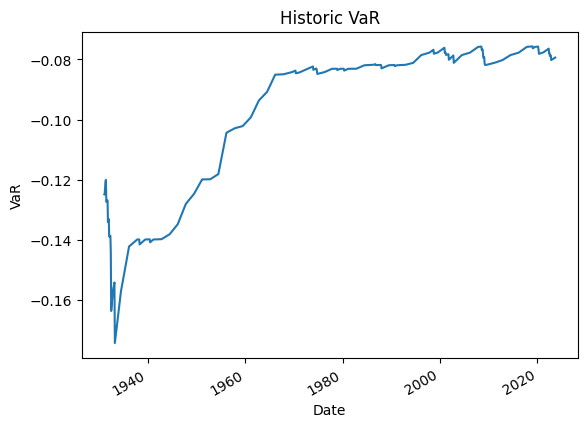

In [2]:
historic_VaR = rets.shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')

exceed = sum(rets < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

### 2. Volatility

- Expanding Window $\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}$

- Rolling Window $\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}$

Use minimum 60 periods for both expanding and rolling windows.

<Axes: title={'center': 'Volatility Estimate'}, xlabel='Date', ylabel='Volatility'>

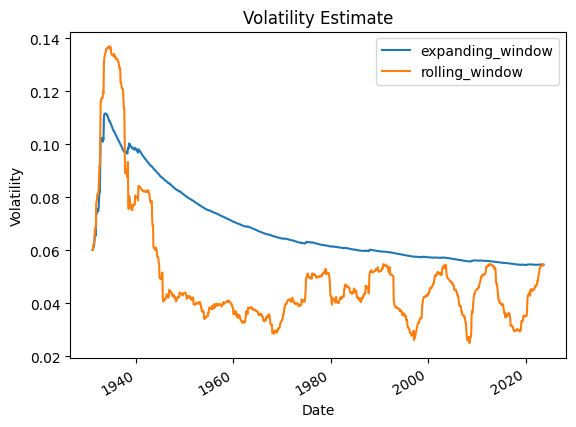

In [3]:
expending_window = np.sqrt((rets**2).expanding(60).mean().shift())
rolling_window = np.sqrt((rets**2).rolling(60).mean().shift())

std = pd.DataFrame({'expanding_window': expending_window, 'rolling_window': rolling_window})
std.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')

When $r \sim \mathcal{N}(\mu,\sigma)$, we can calculate $VaR(\alpha) = \mu - Z_\alpha \sigma$


![](https://pro.arcgis.com/en/pro-app/3.0/tool-reference/spatial-statistics/GUID-CBF63B74-D1B2-44FC-A316-7AC2B1C1D464-web.png)

Here, we assume that $\mu = 0$.

Calculate VaR based on the volatility estimates: $\tilde{r}^{VaR, 0.05}_{t,vol} = −1.65 \sigma_t$

<Axes: title={'center': 'VaR Estimates'}, xlabel='Date', ylabel='5% VaR'>

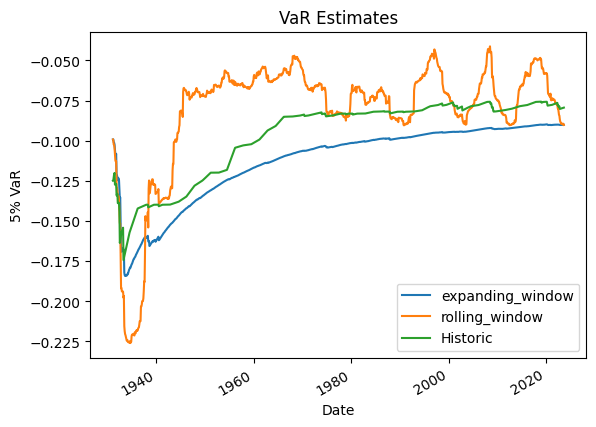

In [4]:
VaR = -1.65 * std
VaR['Historic'] = historic_VaR

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')

The frequency of periods where $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,vol}$

In [5]:
# Comparison between two pandas series using apply
# This only works when the index of two series are the same

var_temp = VaR.dropna()
frequency =  var_temp.apply(lambda x: rets.loc[var_temp.index] < x).mean().to_frame('frequency')
frequency.style.format('{:,.2%}')

,frequency
expanding_window,1.80%
rolling_window,4.95%
Historic,3.15%


### 3. CVaR

$$r_t^{\mathrm{CVaR}_{q, \tau}}=\mu_{\tau, t}-\frac{\phi_{\mathbf{z}}\left(\mathbf{z}_q\right)}{q} \sigma_{\tau, t}$$

<Axes: title={'center': 'CVaR estimates'}, xlabel='Date', ylabel='5% CVaR'>

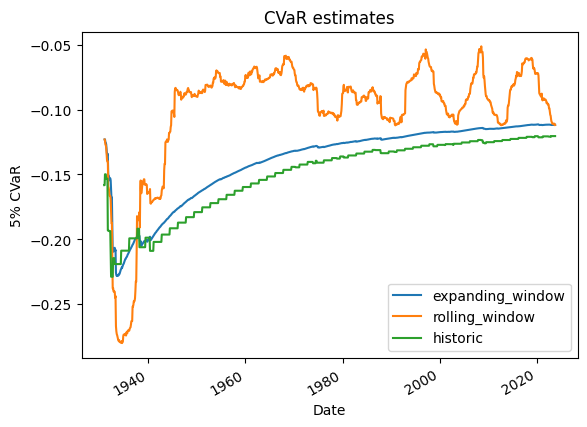

In [36]:
CVaR = -norm.pdf(1.65) / 0.05 * std
CVaR['historic'] = rets.expanding(60).apply(lambda x: x[x < x.quantile(.05)].mean())
CVaR.plot(title = 'CVaR estimates', ylabel = '5% CVaR', xlabel = 'Date')

## 3. Estimating Underperformance

In [8]:
agg_years = [(1965, 1999), (2000, 2023), (1926, 2023)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = data.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')

### 2. Recall the following...

Denote
- Cummulative return $R_{t, t+h} = \Pi_{i=1}^h (1+r_{t+i})$
- Log return $\mathrm{r}_{t, t+h}$
- Log excess return $\tilde{\mathrm{r}}$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return.
$$
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right]
$$

We use
- $\mathrm{r}_{t, t+h}^M \equiv \sum_{i=1}^h \mathrm{r}_{t+i}^M$
- $\overline{\mathrm{r}}_{t, t+h}^M=\frac{1}{h} \sum_{i=1}^h \mathrm{r}_{t+i}^M$

- log-return of SPX $\mathrm{r}_{t, t+h}^M = \log(R_{t,t+h}^M) = \log(\Pi_{i=1}^h R_{t+i}) = \sum_{i=1}^h \mathrm{r}_{t+i}^M$
- log-return pf T-bill $\mathrm{r}_{t, t+h}^f$

#### Sol)

$$
\begin{aligned}
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] &= \operatorname{Pr}\left[\log (R_{t, t+h}^M) - \log (R_{t, t+h}^f) < 0 \right] = \operatorname{Pr}\left[ \mathrm{r}_{t, t+h}^M - \mathrm{r}_{t, t+h}^f < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=1}^{h}{\mathrm{r}}_{t+i}^M - \sum_{i=1}^{h}{\mathrm{r}}_{t+i}^f < 0 \right] = \operatorname{Pr}\left[ \sum_{i=1}^{h}(\mathrm{r}_{t+i}^M - \mathrm{r}_{t+i}^f) < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=1}^{h}\tilde{\mathrm{r}}_{t+i} < 0 \right] = \operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] \\
\end{aligned}
$$

Let annualized mean and volatility of log excess return as $\mu$ and $\sigma$, then we can see

$$
\tilde{\mathrm{r}}_{t, t+h} \sim \mathcal{N}\left(h\mu, h\sigma^2\right)
$$

As such,

$$
\operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] = 
\operatorname{Pr}\left[ Z < \frac{-h\mu}{\sqrt{h}\sigma} \right] = \Phi_{\mathcal{N}}\left(-\sqrt{h}\frac{\mu}{\sigma}\right)
$$

SPX underperforming RF in the next 15 years after 1999: 7.42%
SPX underperforming RF in the next 30 years after 1999: 2.05%


<Axes: >

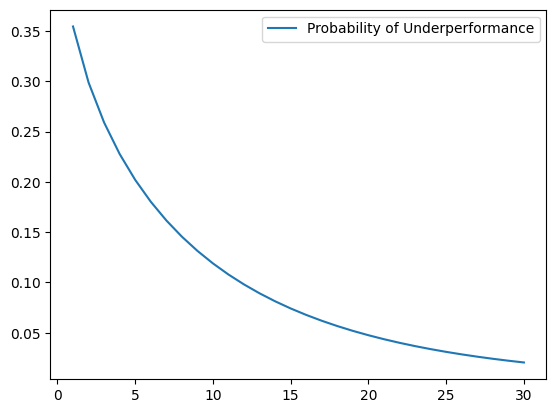

In [19]:
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]

print('SPX underperforming RF in the next 15 years after 1999: {:,.2%}'.
      format(prob(mu = -mu, sigma = sigma, h = 15)))

print('SPX underperforming RF in the next 30 years after 1999: {:,.2%}'.
      format(prob(mu = -mu, sigma = sigma, h = 30)))

h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()

### 4. 

- (a) What was the probability (based on the 1999 estimate of $\mu$,) that the 23-year market return, $R_{t, t+23}^M$, would be smaller than that realized in 2000-2023? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.

In [20]:
mu = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2023', 'mean')].loc[('logs', 'SPX')]
sigma = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')]

prob(-mu, sigma, h = 23).round(4)

0.0544

- (b) Suppose Barnstable had implemented the put-option strategy with the growing strike of $6 \%$ ? Based on the 2000-2023 performance, what is the probability that the 2000-2029 cumulative market return will be low enough to make the puts in the money? For the calculation, update your estimates of $\mu, \sigma$ to be the estimates based on 1965-2023.

#### How to solve (b)?

For next 6 years (2024 ~ 2029), calculate the probability of the cummulative market return being lower than the strike grows of the put option.

$$P\left(\Pi_{t=2000}^{2029} (1+r_t^M) < 1.06^{30}\right)$$


- log-growth of put strike as $\mathrm{r}_G = \log(1.06)$.
- We know $\mu$ and $\sigma$ of $\mathrm{r}^M$ from 1965 - 2023
- We know the performance during 2000 - 2023. 
  - Let the mean of the log return during 2000 - 2023 as $\mu_{perf} = \frac{1}{24}\sum_{t=2000}^{2023}\mathrm{r}_t^M = \frac{1}{24}\mathrm{r}_{2000, 2023}^M$

What we want to calculate is

$$
\begin{aligned}
P(\mathrm{r}_{2000, 2029}^M < 30\mathrm{r}_G)
&= P(\mathrm{r}_{2000, 2023}^M + \mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G)\\
&= P(\mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G - \mathrm{r}_{2000, 2023}^M)\\
&= P(\mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G - 24\mu_{perf})\\
&= P(\mathrm{r}_{2024, 2029}^M < 24(\mathrm{r}_G - \mu_{perf}) + 6\mathrm{r}_G)\\
&= P(1/6 \times \mathrm{r}_{2024, 2029}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G)\\
&= P(\bar{\mathrm{r}}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G)\\
\end{aligned}
$$

Using annualized log return $\mathrm{r}^M \sim \mathcal{N}(\mu, \sigma^2)$ and $\mathrm{r}_{2024, 2029}^M \sim \mathcal{N}(6\mu, 6\sigma^2)$,

$$\bar{\mathrm{r}}^M \sim \mathcal{N}\left(\mu, \frac{1}{6}\sigma^2\right)$$

So, we can calculate the probability as

$$
P(\bar{\mathrm{r}}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G) = \Phi_{\mathcal{N}}\left( -\frac{\frac{24}{6}(\mu_{perf} - \mathrm{r}_G) +  \mu- \mathrm{r}_G}{\sigma/\sqrt{6}}\right)
$$

We can also decompose the target as two part
- $\frac{24}{6}(\mu_{perf} - \mathrm{r}_G)$ : How much we have been over-performing relative to the strike growth
- $\mu - \mathrm{r}_G$ : How much we need to perform relative to the strike growth

In [34]:
strike = np.log(1.06)
mean_return = np.log(1+data['SPX'].loc['1965':]).mean() * 12
sigma = np.log(1 + data['SPX'].loc['1965':]).std() * np.sqrt(12)
performance = np.log(1+data['SPX'].loc['2000':]).mean() * 12
mu = 24/6 * (strike - performance) + strike - mean_return

prob(mu, sigma, 6).round(4)

0.1088

---

# Part 2. Regression

Main references:

- [The Elements of Statistical Learning (ESL) - Trevor Hastie](https://hastie.su.domains/ElemStatLearn/) 
  - Regressions in a statistical learning perspective and math behind
- [Pattern Recognition and Machine Learning (PRML) - Christoper Bishop](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/) 
  - More focused on Bayesian perspective.
  - Good explanation of Curse of Dimensionality

For this Part2, I followed chapter 2, 3 from the ESL

### Ordinary Least Squares

Residual Sum of Squares (RSS) is  a way to evaluate the performance of a regression model.

$$\operatorname{RSS}(\beta)=\sum_{i=1}^N\left(y_i-f\left(x_i\right)\right)^2$$


To optimize linear regression model $f(X)=\beta_0+\sum_{j=1}^p X_j \beta_j =  \mathbf{X} \beta$, we use RSS as a loss function, or equivalently, Mean Squared Error (MSE).

$$
\hat{\beta}=\underset{\beta}{\operatorname{argmin}}\sum_{i=1}^N\left(y_i-\beta_0-\sum_{j=1}^p x_{i j} \beta_j\right)^2 =\underset{\beta}{\operatorname{argmin}} (\mathbf{y}-\mathbf{X} \beta)^T(\mathbf{y}-\mathbf{X} \beta)
$$

Optimizing MSE insteaad of other measures (especially, Mean Absolute Error (MAE)). Why?

1. Easy computation
2. Weigh more on outliers

$$
\begin{aligned}
\frac{\partial \mathrm{RSS}}{\partial \beta} & =-2 \mathbf{X}^T(\mathbf{y}-\mathbf{X} \beta) \\
\frac{\partial^2 \mathrm{RSS}}{\partial \beta \partial \beta^T} & =2 \mathbf{X}^T \mathbf{X} .
\end{aligned}
$$

Assuming that $\mathbf{X}$ has full column rank, and hence $\mathbf{X}^T \mathbf{X}$ is positive definite.

By setting the first derivative to zero, we get

$$
\hat{\beta}=\left(\mathbf{X}^T \mathbf{X}\right)^{-1} \mathbf{X}^T \mathbf{y}
$$


In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

OLS Assumptions:

- Linear relationship: $Y = X\beta + \epsilon$

- Exogeneity: $E[\epsilon_i|X] = 0$ --> Combining with above, $E(Y_j|X) = X_j\beta$

- No perfect multicollinearity: $X^TX$ is invertible
- Homoskedasticity: $Var[\epsilon_i|X] = \sigma^2$
- No serial correlation: $Cov[\epsilon_i, \epsilon_j|X] = 0$ for $i \neq j$
- Normality: $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$


#### 1. Biased prediction: when it is not linear

#### 2. OLS without intercept and R-squared

R^2 with intercept: 0.7923
R^2 without intercept: -0.02203750263171589
R^2 using mean: 0.0


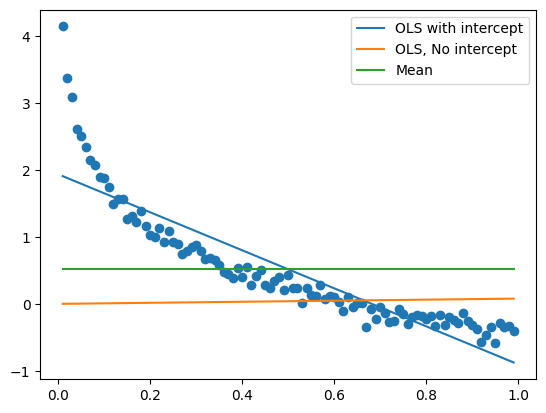

In [3]:
x = np.arange(0.01, 1, 0.01)
y = -np.log(x*1.6)+ np.random.normal(0, 0.1, len(x))

m1 = sm.OLS(y, sm.add_constant(x)).fit()
b1 = m1.params
m2 = sm.OLS(y, x).fit()
b2 = m2.params

print(f"R^2 with intercept: {m1.rsquared.round(4)}")
print(f"R^2 without intercept: {1 - (y - b2 * x).std() / y.std()}")
print(f"R^2 using mean: {1 - (y - np.mean(y)).std() / y.std()}")

plt.scatter(x, y)
plt.plot(x, b1[0] + b1[1] * x, label = 'OLS with intercept')
plt.plot(x, b2 * x, label = 'OLS, No intercept')
plt.plot(x, np.mean(y) * np.ones(len(x)), label = 'Mean')
plt.legend()


How to deal with non-linearity?

1. Polynomial Regression: Include higher order term

2. Local Regression: Solve weighted least squares problem
    $$argmin \sum_{i=1}^n w_i(x)\left\{Y_i-P_x\left(x_i, \boldsymbol{\beta}\right)\right\}^2$$

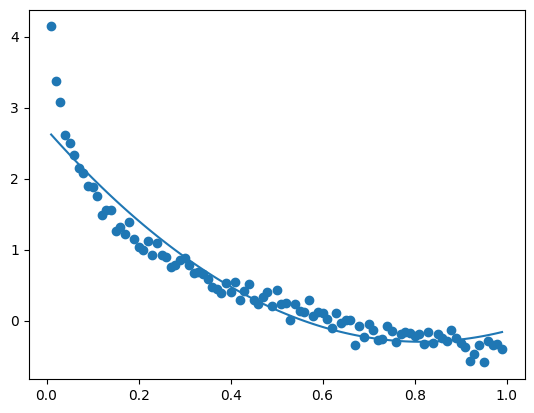

In [4]:
b3 = sm.OLS(y, sm.add_constant(pd.DataFrame({'x1':x, 'x2':x**2}))).fit().params
plt.scatter(x, y)
plt.plot(x, b3[0] + b3[1] * x + b3[2] * x**2, label = 'OLS with intercept')

#### Not exogenous --> My explanation during the session was inaccurate. Pardon my mistake

Here, I assumed that $y = x + \epsilon$ where $\epsilon \sim exp(\lambda = 1)$

By fitting the data on $y = \beta_0 + \beta_1 x$, it results with $\hat{\beta}_0 = 0.98, \hat{\beta}_1 = 0.95$.

However the true value should be $\beta_0 = 0, \beta_1 = 1$.

We can see that the estimated parameter is far from the true parameter (specifically $\beta_0$).

[0.9768236  0.94557063]


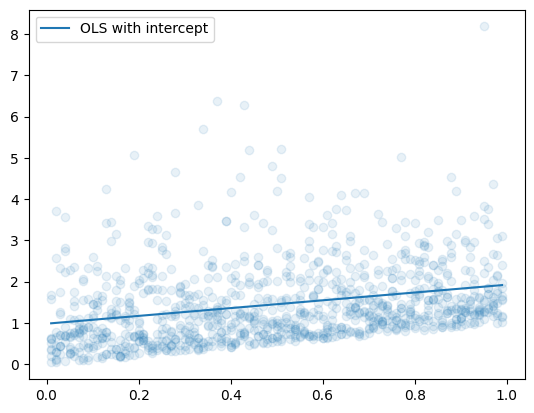

In [19]:
n=10
x = np.concatenate([np.arange(0.01, 1, 0.01)] * n)
y = x + np.random.exponential(1, len(x))

m1 = sm.OLS(y, sm.add_constant(x)).fit()
b1 = m1.params

plt.scatter(x, y, alpha = 0.1)
plt.plot(x, b1[0] + b1[1] * x, label = 'OLS with intercept')
plt.legend()

print(b1)

#### 3. Multicolinearity and Penalized Regression

In [240]:
y = data['SPX'].shift(-1).iloc[:-1]
x = data.iloc[:-1]
x2 = x.iloc[:,:-1].copy()

In [241]:
X = sm.add_constant(x)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPX   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.431
Date:                Fri, 13 Oct 2023   Prob (F-statistic):             0.0327
Time:                        18:45:03   Log-Likelihood:                 1758.4
No. Observations:                1171   AIC:                            -3511.
Df Residuals:                    1168   BIC:                            -3496.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0097      0.002      4.192      0.000       0.005       0.014
SPX               -0.0709      0.215     -0.330      0.742      -0.493       0.351
TB1M              -0.2162      0.428     -0.505      0.614      -1.056       0.623
excess_returns     0.1453      0.214      0.679      0.497      -0.274       0.565
==============================================================================
Omnibus:                      217.547   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3683.351
Skew:                           0.317   Prob(JB):                         0.00
Kurtosis:                      11.665   Cond. No.                     2.38e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [204]:
display(X.head())
np.linalg.matrix_rank(X)

,const,SPX,TB1M,excess_returns
date,,,,
1926-01-30,1.0,-0.001783,0.003061,-0.004844
1926-02-27,1.0,-0.033296,0.002612,-0.035908
1926-03-31,1.0,-0.057708,0.002601,-0.060309
1926-04-30,1.0,0.038522,0.002270,0.036252
1926-05-28,1.0,0.013623,0.002691,0.010932


3

In [205]:
np.linalg.inv(X.T @ X) @ X.T @ y

0    0.008439
1    0.086560
2   -0.308072
3    0.051338
dtype: float64

In [206]:
np.linalg.cholesky(X.T @ X)

LinAlgError: Matrix is not positive definite

In [207]:
np.linalg.eigvals(X.T @ X) > 0

array([ True,  True,  True, False])

In [208]:
X2 = sm.add_constant(x2)
np.linalg.cholesky(X2.T @ X2)

array([[ 3.42198773e+01,  0.00000000e+00,  0.00000000e+00],
       [ 3.25821598e-01,  1.84978864e+00,  0.00000000e+00],
       [ 8.97543782e-02, -1.16048254e-03,  8.41213259e-02]])

In [209]:
np.linalg.inv(X2.T @ X2)

array([[ 1.85706864e-03, -3.01570206e-03, -3.71494952e-01],
       [-3.01570206e-03,  2.92306469e-01,  8.86552145e-02],
       [-3.71494952e-01,  8.86552145e-02,  1.41314843e+02]])

In [210]:
sm.OLS(y, X2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPX   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.431
Date:                Fri, 13 Oct 2023   Prob (F-statistic):             0.0327
Time:                        12:19:51   Log-Likelihood:                 1758.4
No. Observations:                1171   AIC:                            -3511.
Df Residuals:                    1168   BIC:                            -3496.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.002      4.192      0.000       0.005       0.014
SPX            0.0744      0.029      2.550      0.011       0.017       0.132
TB1M          -0.3615      0.642     -0.563      0.573      -1.620       0.897
==============================================================================
Omnibus:                      217.547   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3683.351
Skew:                           0.317   Prob(JB):                         0.00
Kurtosis:                      11.665   Cond. No.                         407.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [211]:
# OLS beta from formula
np.linalg.inv(X2.T @ X2) @ X2.T @ y

0    0.009749
1    0.074415
2   -0.361508
dtype: float64

Increasing the diagonal Term of $X^TX$ to make it invertible


$\hat{\beta}=\left(X^{\prime} X+\lambda I_p\right)^{-1} X^{\prime} Y$

In [212]:
# Positive definite
np.linalg.eigvals(X.T @ X + 0.1 * np.eye(4)) > 0

array([ True,  True,  True,  True])

In [87]:
np.linalg.cholesky(X.T @ X + 0.1 * np.eye(4))

array([[ 3.42213384e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.25807686e-01,  1.87662651e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 8.97505460e-02, -1.14255568e-03,  3.27226415e-01,
         0.00000000e+00],
       [ 2.36057140e-01,  1.82448196e+00, -2.18136734e-02,
         4.51534651e-01]])

### Ridge Regression

$$
\begin{aligned}
\hat{\beta}^{\text {ridge }}
&=\underset{\beta}{\operatorname{argmin}}\left\{\sum_{i=1}^N\left(y_i-\beta_0-\sum_{j=1}^p x_{i j} \beta_j\right)^2+\lambda \sum_{j=1}^p \beta_j^2\right\}\\
&= \underset{\beta}{\operatorname{argmin}}(\mathbf{y}-\mathbf{X} \beta)^T(\mathbf{y}-\mathbf{X} \beta)+\lambda \beta^T \beta
\end{aligned}
$$

Solving above problem, we get

$$\hat{\beta_{\text {ridge }}}=\left(X^{\prime} X+\lambda I_p\right)^{-1} X^{\prime} Y$$

In [227]:
import sklearn.linear_model as lm

ridge_model = lm.Ridge(alpha = 0.1).fit(X, y)
ridge_model.coef_

array([ 0.        ,  0.02652148, -0.02078057,  0.04730205])

In [228]:
np.linalg.inv(X.T @ X + 0.1 * np.eye(4)) @ X.T @ y

0    0.008985
1    0.026533
2   -0.020759
3    0.047292
dtype: float64

Properties:
- For orthogonal covariates, $\mathrm{X}^{\prime} \mathrm{X}=\mathrm{nI}_{\mathrm{p}}, \hat{\beta_{\text {ridge }}}=\frac{\mathrm{n}}{\mathrm{n}+\lambda} \hat{\beta_{\mathrm{ls}}}$. Hence, in this case, the ridge estimator always produces shrinkage towards $0 . \lambda$ controls the amount of shrinkage.

- $\operatorname{var}\left(\hat{\beta_{\text {ridge }}}\right)=\sigma^2\left(X^{\prime} X+\lambda I_p\right)^{-1} X^{\prime} X\left(X^{\prime} X+\lambda I_p\right)^{-1}$

![](https://online.stat.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson04/ridge_regression_geomteric/index.png)

Let's start from singlular value decomposition of $X$. $\mathbf{X}=\mathbf{U D V}^T$
Columns of $U$ are spanning the column space of $X$, while the columns of $V$ are spanning the row space of $X$. $D$ is a diagonal matrix with singular values $d_1 \geq d_2 \geq \cdots \geq d_p \geq 0$.

Comparing the solution of OLS and Ridge Regression,

$$
\begin{aligned}
\mathbf{X} \hat{\beta}^{\mathrm{ls}} & =\mathbf{X}\left(\mathbf{X}^T \mathbf{X}\right)^{-1} \mathbf{X}^T \mathbf{y} \\
& =\mathbf{U U}^T \mathbf{y}
\end{aligned}
$$

Here, $U^T y$ are the coordinates of y with respect to the orthonormal basis

$$
\begin{aligned}
\mathbf{X} \hat{\beta}^{\text {ridge }} & =\mathbf{X}\left(\mathbf{X}^T \mathbf{X}+\lambda \mathbf{I}\right)^{-1} \mathbf{X}^T \mathbf{y} \\
& =\mathbf{U} \mathbf{D}\left(\mathbf{D}^2+\lambda \mathbf{I}\right)^{-1} \mathbf{D} \mathbf{U}^T \mathbf{y} \\
& =\sum_{j=1}^p \mathbf{u}_j \frac{d_j^2}{d_j^2+\lambda} \mathbf{u}_j^T \mathbf{y},
\end{aligned}
$$

Ridge regression shirinks the coordinates by the factor of $d_j^2 /\left(d_j^2+\lambda\right)$

#### LASSO

$$
\hat{\beta}^{\text {lasso }}=\underset{\beta}{\operatorname{argmin}}\left\{\frac{1}{2} \sum_{i=1}^N\left(y_i-\beta_0-\sum_{j=1}^p x_{i j} \beta_j\right)^2+\lambda \sum_{j=1}^p\left|\beta_j\right|\right\} .
$$

![](https://miro.medium.com/v2/resize:fit:761/1*nrWncnoJ4V_BkzEf1pd4MA.png)


How is the LASSO optimized?: Modified algorithm based on Least Angle Regression (Refer to ESL chapter 3 if you are interested!)

Lasso fit from the data, set $\beta_j = 0$ for all $j$.

In [262]:
lasso_model = lm.Lasso(alpha = 0.001).fit(X, y)
lasso_model.coef_

array([ 0.,  0., -0.,  0.])